#### Write a Spark program to analyze the text data.

In this notebook, we have a dataset of user comments for youtube videos related to animals or pets. We will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners.

# 0. Data Exploration and Cleaning

In [0]:
df_clean=spark.read.csv("/FileStore/tables/animals_comments.csv",inferSchema=True,header=True)
df_clean.show(10)

In [0]:
df_clean.count() 

In [0]:
df_clean = df_clean.na.drop(subset=["comment"])
df_clean.count()

In [0]:
# find user with preference of dog and cat
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# you can user your ways to extract the label

df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

In [0]:
df_clean.show(10)

+--------------------+------+-------------------------------------+-----+
|        creator_name|userid|                              comment|label|
+--------------------+------+-------------------------------------+-----+
|        Doug The Pug|  87.0|                 I shared this to ...|    0|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|    0|
|         bulletproof| 530.0|                 stop saying get e...|    0|
|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|    0|
|              ojatro|1031.0|                 I wanna see what ...|    0|
|     Tingle Triggers|1212.0|                 Well shit now Im ...|    0|
|Hope For Paws - O...|1806.0|                 when I saw the en...|    0|
|Hope For Paws - O...|2036.0|                 Holy crap. That i...|    0|
|          Life Story|2637.0|武器はクエストで貰えるんじゃないん...|    0|
|       Brian Barczyk|2698.0|                 Call the teddy Larry|    0|
+--------------------+------+-----------------------------

# 1. Data preprocessing and Build the classifier

In [0]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")

word2Vec = Word2Vec(vectorSize=20,inputCol="words", outputCol="features")

In [0]:
# Only select first 100000 of data set
df_clean.createOrReplaceTempView("table1")
df_clean = spark.sql("select * from table1 limit 100000")

In [0]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, word2Vec])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_clean)
dataset = pipelineFit.transform(df_clean)

In [0]:
dataset.show(10)

+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
|        creator_name|userid|                              comment|label|               words|            features|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
|        Doug The Pug|  87.0|                 I shared this to ...|    0|[i, shared, this,...|[0.11568405682390...|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|    0|       [super, cute]|[0.60218596458435...|
|         bulletproof| 530.0|                 stop saying get e...|    0|[stop, saying, ge...|[0.14560951525345...|
|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|    0|[tenho, uma, jibo...|[0.09802778065204...|
|              ojatro|1031.0|                 I wanna see what ...|    0|[i, wanna, see, w...|[0.09983215887438...|
|     Tingle Triggers|1212.0|                 Well shit now Im ...|    0|[w

In [0]:
(lable0_train,lable0_test)=dataset.filter(col('label')==1).randomSplit([0.7, 0.3],seed = 100)
(lable1_train, lable1_ex)=dataset.filter(col('label')==0).randomSplit([0.005, 0.995],seed = 100)
(lable1_test, lable1_ex2)=lable1_ex.randomSplit([0.002, 0.998],seed = 100)

In [0]:
trainingData = lable0_train.union(lable1_train)
testData=lable0_test.union(lable1_test)

In [0]:
print("Dataset Count: " + str(dataset.count()))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

# 2. Build ML Models

## Logistic Regression

In [0]:
from pyspark.ml.classification import LogisticRegression

# Model Fitting
LR = LogisticRegression(featuresCol='features', labelCol='label',maxIter=10)

lr_model = LR.fit(trainingData)

# Model Prediction
prediction = lr_model.transform(testData)
prediction.show(10)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


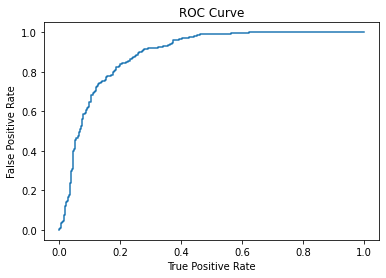

Training set areaUnderROC: 0.8897964912280696


In [0]:
import matplotlib.pyplot as plt
# ROC Curve
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
# Area under the curve
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


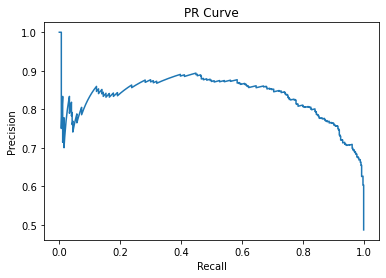

In [0]:
# PR Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.show()

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


def get_evaluation_result(predictions):
  evaluator = BinaryClassificationEvaluator(
      labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
  AUC = evaluator.evaluate(predictions)

  TP = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 1.0)].count()
  FP = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 1.0)].count()
  TN = predictions[(predictions["label"] == 0) & (predictions["prediction"] == 0.0)].count()
  FN = predictions[(predictions["label"] == 1) & (predictions["prediction"] == 0.0)].count()

  accuracy = (TP + TN)*1.0 / (TP + FP + TN + FN)
  precision = TP*1.0 / (TP + FP)
  recall = TP*1.0 / (TP + FN)


  print ("True Positives:", TP)
  print ("False Positives:", FP)
  print ("True Negatives:", TN)
  print ("False Negatives:", FN)
  print ("Test Accuracy:", accuracy)
  print ("Test Precision:", precision)
  print ("Test Recall:", recall)
  print ("Test AUC of ROC:", AUC)

print("Prediction result summary for Logistic Regression Model:  ")
get_evaluation_result(prediction)

Prediction result summary for Logistic Regression Model:  
True Positives: 159
False Positives: 42
True Negatives: 146
False Negatives: 24
Test Accuracy: 0.8221024258760108
Test Precision: 0.7910447761194029
Test Recall: 0.8688524590163934
Test AUC of ROC: 0.8847227066620164


##### Parameter Tuning and 5-fold cross-validation

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

grid = ParamGridBuilder().addGrid(lr_model.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=LR,evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cvModel = cv.fit(trainingData)

In [0]:
best_model = cvModel.bestModel
trainingSummary = best_model.summary

Out[36]: <pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary at 0x7f61e4f199d0>

In [0]:
# Overall Accuracy From 5-fold CV
evaluator.evaluate(cvModel.transform(trainingData))

Out[54]: 0.8379084967320262

## Random Forest

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.show(10)

+------------------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|      creator_name|   userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------------+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|Alex Knappenberger|1070572.0|Look  he did not ...|    1|[look, he, did, n...|[0.10223358735379...|[4.70992435358993...|[0.23549621767949...|       1.0|
|    Big Cat Rescue|2378111.0|Okay but honestly...|    1|[okay, but, hones...|[0.12656392716792...|[4.15745262559963...|[0.20787263127998...|       1.0|
|    Big Cat Rescue|2477786.0|Definitely going ...|    1|[definitely, goin...|[0.05577077078359...|[7.99462526984985...|[0.39973126349249...|       1.0|
|  Brave Wilderness| 349705.0|Me: *Watches this...|    1|[me, watches, thi...|[0.1

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


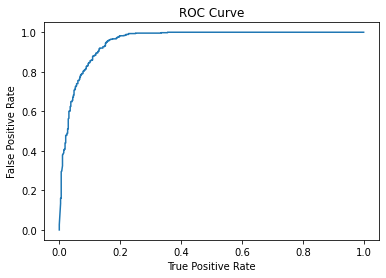

Training set areaUnderROC: 0.9547111111111111


In [0]:
# ROC Curve
trainingSummary = rfModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
# Area under the curve
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


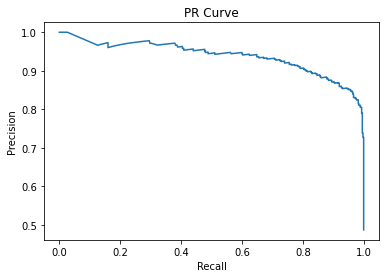

In [0]:
# PR Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.show()

In [0]:
print("Prediction result summary for Random Forest Model:  ")
get_evaluation_result(predictions)

Prediction result summary for Random Forest Model:  
True Positives: 165
False Positives: 36
True Negatives: 152
False Negatives: 18
Test Accuracy: 0.8544474393530997
Test Precision: 0.8208955223880597
Test Recall: 0.9016393442622951
Test AUC of ROC: 0.9298192070689462


# 3. Get insigts of Users

- NLP Topic Modeling

In [0]:
# Only select first 100000 of data set
dataset.createOrReplaceTempView("table2")
df_pet = spark.sql("select words from table2 where label=1")
df_no_pet = spark.sql('select words from table2 where label=0')

In [0]:
# process the comments that users have pets
from pyspark.ml.feature import StopWordsRemover
word_pet = df_pet.select('words')

stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cats', 'cat', 'kitty', 'much', 'really', 'love','like','dont','know','want','thin',\
                    'see','also','never','go','ive']

remover1 = StopWordsRemover(inputCol="raw", outputCol="filtered")
core = remover1.getStopWords()
core = core + stopwords_custom
remover = StopWordsRemover(inputCol="words", outputCol="filtered",stopWords=core)
word_pet = remover.transform(word_pet)

wc = word_pet.select('filtered').rdd.flatMap(lambda a: a.filtered).countByValue()

In [0]:
#wcSorted = wc.sort(lambda a: a[1])
wcSorted = sorted(wc.items(), key=lambda kv: kv[1],reverse = True)
wcSorted

Out[71]: [('video', 46),
 ('good', 44),
 ('time', 43),
 ('puppy', 42),
 ('looks', 41),
 ('back', 40),
 ('help', 37),
 ('please', 36),
 ('name', 35),
 ('home', 35),
 ('lol', 34),
 ('old', 32),
 ('food', 32),
 ('still', 32),
 ('people', 32),
 ('thats', 31),
 ('always', 31),
 ('little', 31),
 ('even', 31),
 ('died', 30),
 ('take', 30),
 ('didnt', 30),
 ('well', 30),
 ('going', 29),
 ('2', 29),
 ('3', 29),
 ('think', 28),
 ('thing', 28),
 ('years', 28),
 ('great', 28),
 ('keep', 27),
 ('videos', 27),
 ('house', 27),
 ('cant', 27),
 ('make', 26),
 ('vet', 26),
 ('away', 26),
 ('doesnt', 25),
 ('hope', 25),
 ('two', 25),
 ('play', 24),
 ('put', 24),
 ('eat', 23),
 ('day', 23),
 ('give', 23),
 ('live', 23),
 ('cute', 23),
 ('way', 23),
 ('lot', 23),
 ('found', 23),
 ('need', 22),
 ('new', 22),
 ('life', 22),
 ('something', 21),
 ('us', 21),
 ('made', 21),
 ('training', 21),
 ('watching', 21),
 ('mom', 20),
 ('care', 20),
 ('year', 20),
 ('wish', 20),
 ('work', 20),
 ('happy', 19),
 ('someone'

Out[75]: (-0.5, 399.5, 199.5, -0.5)

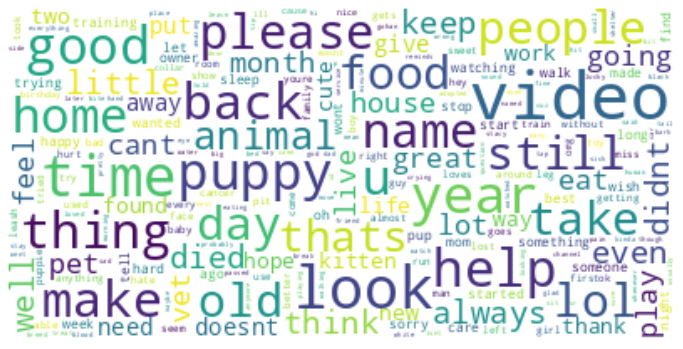

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([(k + " ")*v for k,v in wc.items()])

wcloud = WordCloud(background_color="white", max_words=20000, collocations = False,
               contour_width=3, contour_color='steelblue',max_font_size=40)

# Generate a word cloud image
wcloud.generate(text)

# Display the generated image:
# the matplotlib way:
fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")

In [0]:
# process the comments that users do not have pets
from pyspark.ml.feature import StopWordsRemover
word_pet = df_no_pet.select('words')

stopwords_custom = ['im', 'get', 'got', 'one', 'hes', 'shes', 'dog', 'dogs', 'cats', 'cat', 'kitty', 'much', 'really', 'love','like','dont','know','want','thin',\
                    'see','also','never','go','ive']

remover1 = StopWordsRemover(inputCol="raw", outputCol="filtered")
core = remover1.getStopWords()
core = core + stopwords_custom
remover = StopWordsRemover(inputCol="words", outputCol="filtered",stopWords=core)
word_pet = remover.transform(word_pet)

wc = word_pet.select('filtered').rdd.flatMap(lambda a: a.filtered).countByValue()

In [0]:
#wcSorted = wc.sort(lambda a: a[1])
wcSorted = sorted(wc.items(), key=lambda kv: kv[1],reverse = True)
wcSorted

Out[77]: [('video', 5391),
 ('good', 3984),
 ('great', 3373),
 ('cute', 3299),
 ('videos', 3227),
 ('u', 3203),
 ('people', 3130),
 ('coyote', 2874),
 ('think', 2586),
 ('thank', 2563),
 ('lol', 2489),
 ('n', 2390),
 ('animals', 2332),
 ('time', 2325),
 ('make', 2261),
 ('happy', 2091),
 ('m', 2052),
 ('3', 2045),
 ('keep', 2006),
 ('please', 1961),
 ('nice', 1946),
 ('que', 1877),
 ('day', 1867),
 ('v', 1819),
 ('hope', 1805),
 ('channel', 1799),
 ('awesome', 1775),
 ('thats', 1765),
 ('amazing', 1764),
 ('de', 1757),
 ('y', 1745),
 ('guys', 1732),
 ('beautiful', 1727),
 ('thanks', 1712),
 ('looks', 1702),
 ('name', 1685),
 ('god', 1685),
 ('new', 1683),
 ('little', 1682),
 ('always', 1642),
 ('best', 1631),
 ('2', 1627),
 ('well', 1619),
 ('going', 1614),
 ('man', 1606),
 ('cant', 1604),
 ('even', 1574),
 ('way', 1553),
 ('look', 1552),
 ('omg', 1509),
 ('1', 1502),
 ('need', 1501),
 ('life', 1497),
 ('first', 1482),
 ('ever', 1479),
 ('back', 1468),
 ('cool', 1464),
 ('work', 1408),

Out[78]: (-0.5, 399.5, 199.5, -0.5)

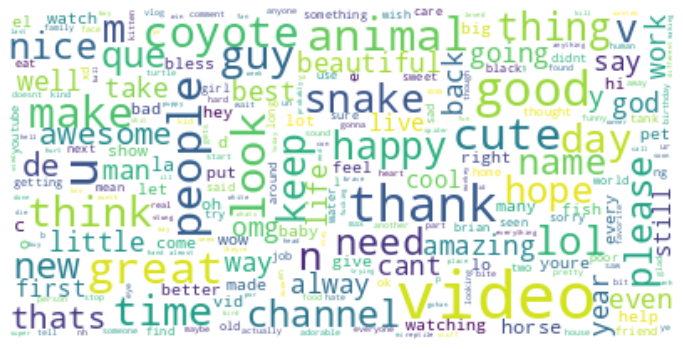

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([(k + " ")*v for k,v in wc.items()])

wcloud = WordCloud(background_color="white", max_words=20000, collocations = False,
               contour_width=3, contour_color='steelblue',max_font_size=40)

# Generate a word cloud image
wcloud.generate(text)

# Display the generated image:
# the matplotlib way:
fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")